In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import ast 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,precision_score

# Movie Recommendation Project

In this project we will try to predict which movie should be your next movie.

At first, as a POC we will build a recommendation system that is content based filtering, the system will offer generalized recommendations to every user based on the popularity, the genres and the movie's runtime. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Later on, we will try to extend the algorithm with adding demographic filtering based models. Giving a user a more specific recommendation based on his rating on other movies and taking into consideration the popularity of a certian genres in the year he is watching.
 
Some interesting analysis we are hoping to come a cross while working on this:

- Genre popularity based on the year, we can tell by that if there was a major event that may cause a specific genre to be more popular
- What is the perfect runtime? is there such a thing?
- What year is the best year to release movie?
- Are people consistently watching the same genre films? e.g. People who watch war, crime and thriller films likely to watch only those genres

_Because of low-quality data on old movies, we will **not** ignore movies that were released after the year of watching parameter._

## Let's look at our data

In [3]:
# movies_raw_df = pd.read_csv('https://www.dropbox.com/s/j9vxjw3g1s7wqsg/movies_metadata.csv?dl=1')
# rating_raw_df = pd.read_csv('https://www.dropbox.com/s/tizyp5zreilielv/ratings.csv?dl=1')

movies_raw_df = pd.read_csv('movies.csv')
ratings_raw_df = pd.read_csv('ratings.csv')

/Users/culturetripisrael/anaconda3/envs/movie-recommendation-notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### MovieLens's Movies Dataset Features:

- adult - Is it an adult film
- budget - How much money was invested
- genres - Genres the movie classified to(JSON format)
- imdb_id - IMDb's ID
- overview - Description of the movie
- popularity - A numeric quantity specifying the movie popularity
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date of the movie release
- revenue - How much revenue the movie generated worldwide
- runtime - How long is the movie in minutes
- tagline - Movie's tagline
- title - Title of the movie
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

#### Rating Dataset Features:

- userId - A unique value for each user
- movieId - A unique movie id in MovieLens
- rating - The user rating for that movie
- timestamp - The time the movie was rated

## Taking A Look At Our Movies Dataset

#### Cleaning MovieLens's Movies Dataset

In [4]:
movies_df = movies_raw_df.copy()

# After inspections in df we found duplicated rows so we'll drop the to keep unique values
duplications = len(movies_df['id']) - len(movies_df.drop_duplicates(['id']))
print( 'REMOVED: {} duplicates'.format(duplications) )
movies_df.drop_duplicates(['id'],inplace=True)

# create a new column with the release year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'],errors='coerce').dt.year.fillna(0)
print( 'REMOVED: {} movies without release year'.format(len(movies_df[ movies_df['release_year'] == 0 ])) )
movies_df = movies_df[ movies_df['release_year'] != 0 ]

# clearing popularity column
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'],errors='coerce')
print( 'REMOVED: {} movies without popularity'.format(len(movies_df[ movies_df['popularity'] == 0 ])) )
movies_df = movies_df[ movies_df['popularity'] != 0 ]

# Remove unreleased films
print( 'REMOVED: {} movies that not released yet'.format(len(movies_df[ movies_df['status'] != 'Released' ])) )
movies_df = movies_df[ movies_df['status'] == 'Released' ]

# finding the longest sequence of years with movie count higher then 10
def find_movies_range(df, threshold):
    # group by year
    groupby_year = df.groupby('release_year').size().reset_index(name='count').sort_values(['release_year'])
    # for each year, if it has sufficient number of movies
    groupby_year['count'] = groupby_year['count'].apply(lambda x: x < threshold)
    groupby_year.reset_index(inplace=True)
    # search for sequence of years with 10 >= movies
    groupby_year = groupby_year.groupby(groupby_year['count'].cumsum()).agg(
        {'release_year':['count', 'min', 'max']})
    groupby_year.columns = groupby_year.columns.droplevel()
    # get the longest year sequence in the dataset
    return groupby_year[groupby_year['count']==groupby_year['count'].max()]

years_range = find_movies_range( movies_df, 10 )

# clean movies out of limit
movies_df = movies_df[(movies_df['release_year'] > int(years_range['min'].values)) & (movies_df['release_year'] < int(years_range['max'].values))]

print('Cleaning anomalies years, we are left with {} to {}'.format(
    int(years_range['min'].values),int(years_range['max'].values))
)

"""
Preparing our genres column for usage
Genres are stored as JSONs in our dataset, lets convert to it to hot-one format
"""
genres_list = set()
for index, row in movies_df.iterrows():
    # extract genres
    movies_genres = ast.literal_eval(row['genres'])
    for genre in movies_genres:
        # if genre is not a column, generate the column and set all to 0
        if genre['name'] not in movies_df:
            genres_list.add(genre['name'])
            movies_df[ genre['name'] ] = 0
        movies_df.at[index, genre['name']] = 1

# removing unnecessary columns
movies_df.drop(['imdb_id','homepage','adult','belongs_to_collection','production_countries','overview','tagline',
                'video', 'genres','poster_path', 'spoken_languages','status'],inplace=True,axis=1)    

REMOVED: 30 duplicates
REMOVED: 90 movies without release year
REMOVED: 40 movies without popularity
REMOVED: 437 movies that not released yet
Cleaning anomalies years, we are left with 1911 to 2017


#### Genres

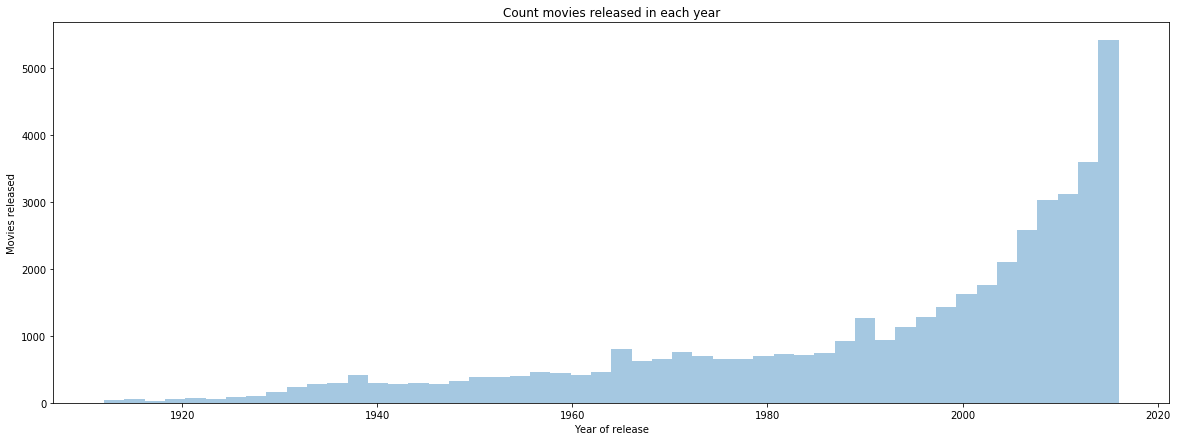

In [5]:
# Get a feeling of the movies and their release year
f, axes = plt.subplots(figsize=(20, 7))
sns.distplot(movies_df['release_year'], ax=axes, kde=False)
plt.xlabel('Year of release')
plt.ylabel('Movies released')
plt.title('Count movies released in each year')
plt.show()

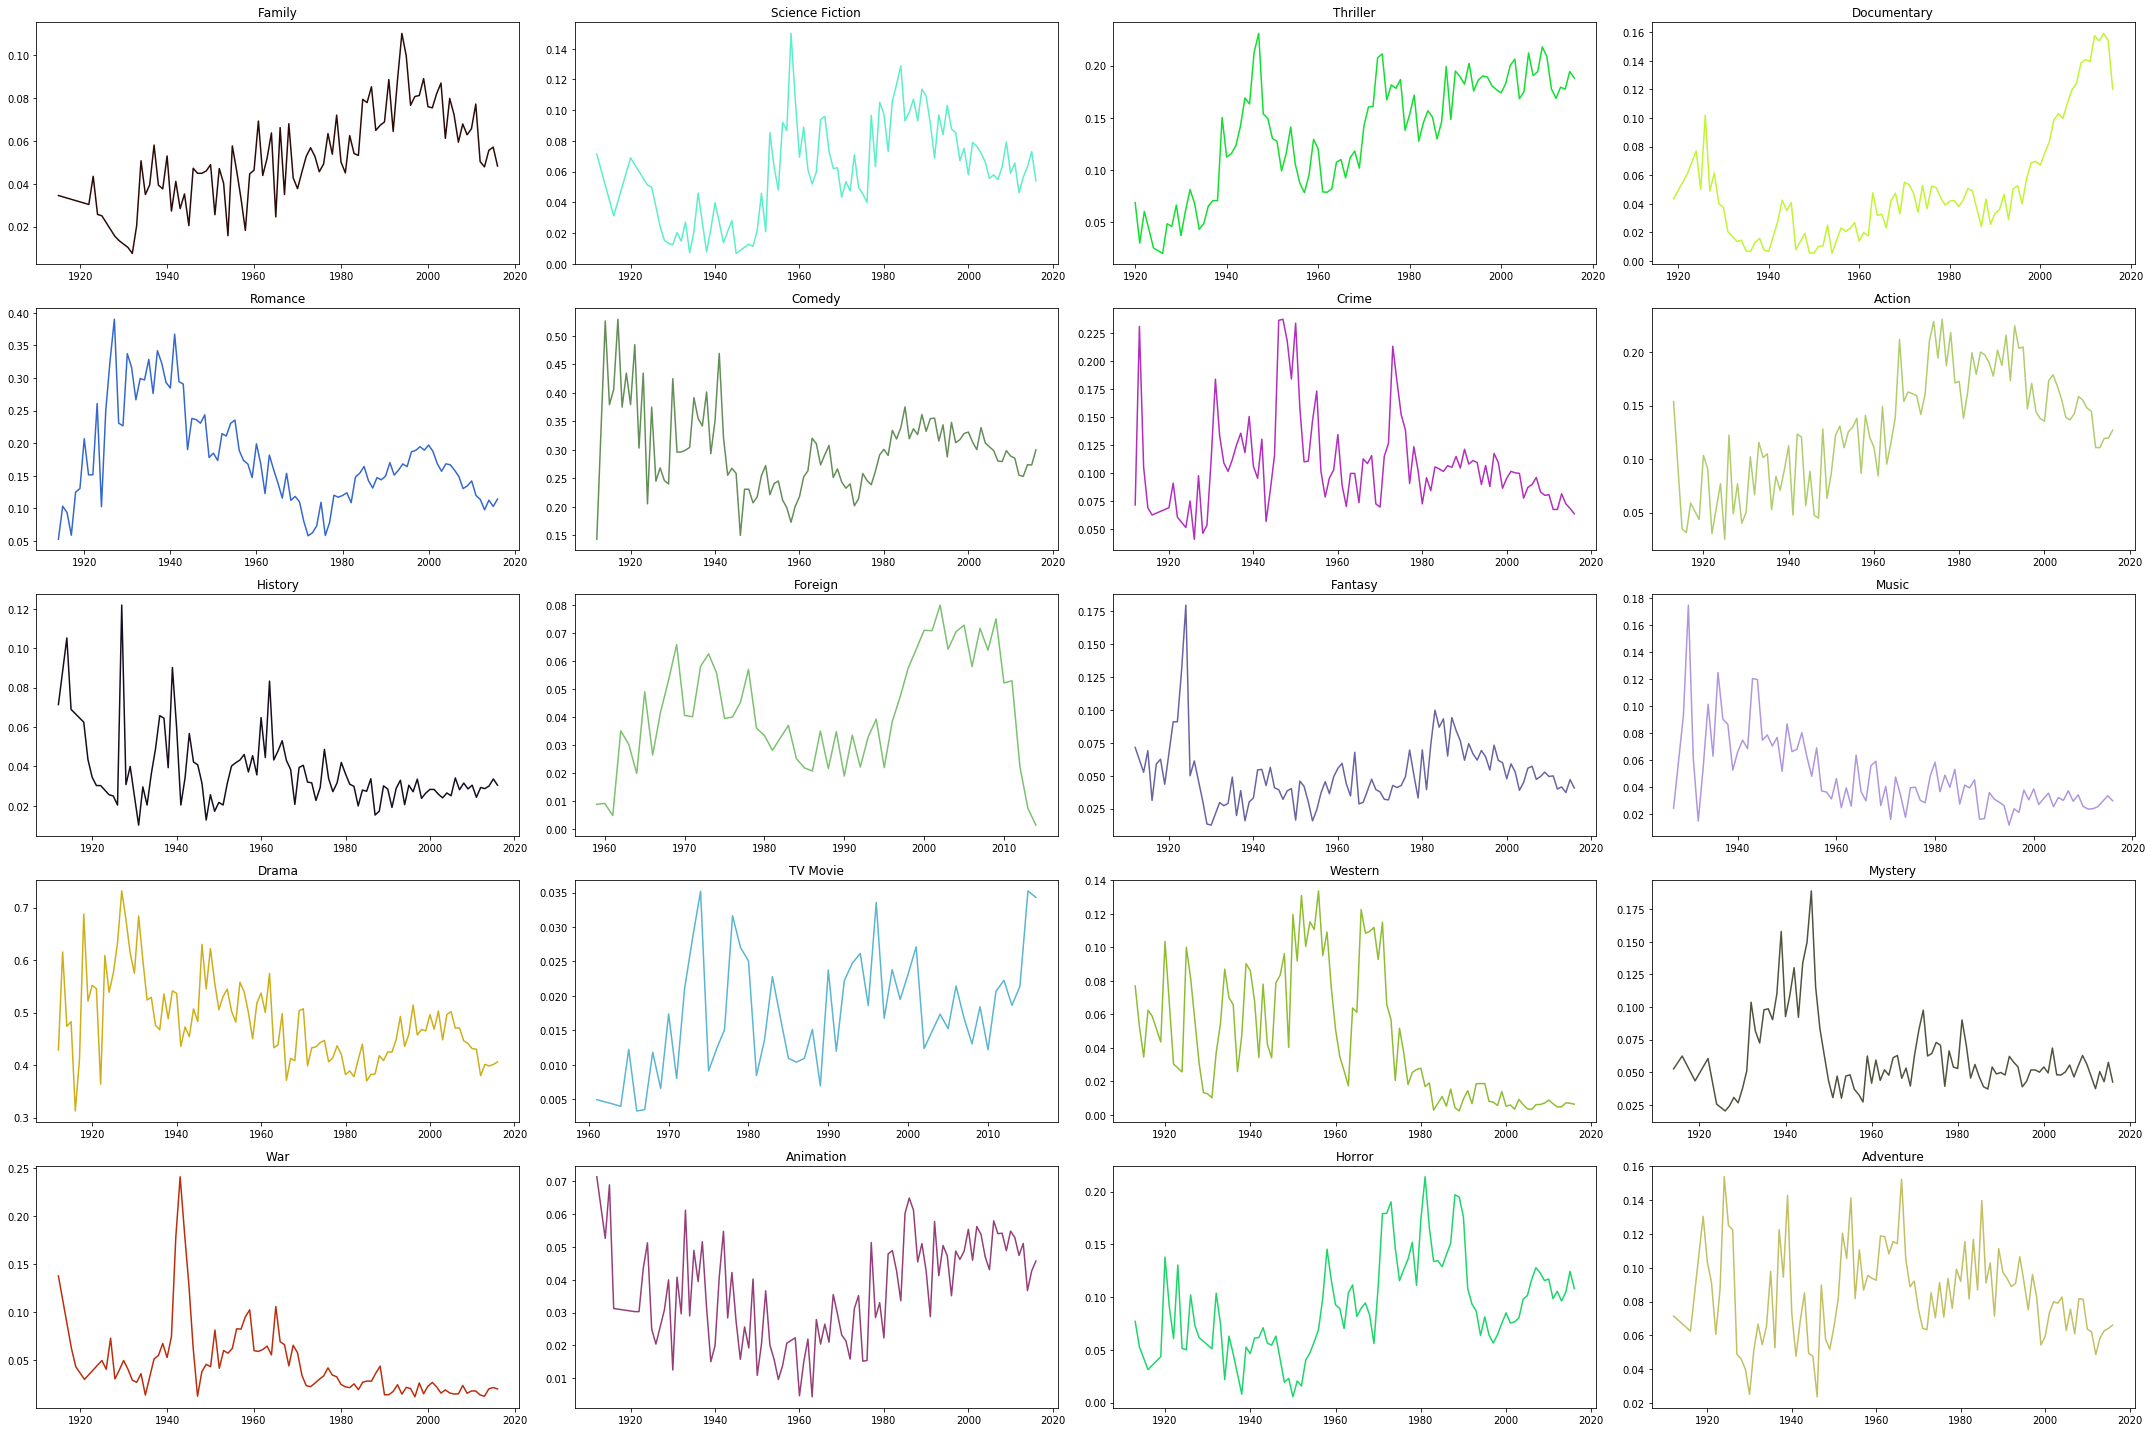

In [59]:
# print(movies_df[movies_df['Animation'] == 1].groupby(['release_year','Animation']).size().to_frame('count').reset_index())

d = movies_df[movies_df['Animation'] == 1].groupby(['release_year','Animation']).size().to_frame('count').reset_index()
d = d.drop('Animation',axis=1)

i = 1
fig = plt.figure(figsize=(30,20))

for genre in genres_list:
    plt.subplot(5,4,i)
    d = movies_df[movies_df[genre] == 1].groupby(['release_year',genre]).size().to_frame('count').reset_index()
    data = d.set_index('release_year').drop(genre,axis=1)['count'] / movies_df.groupby('release_year').size()
    data.fillna(0)
    sns.lineplot(data=data,color=np.random.rand(3,))
    plt.xlabel('')
    plt.ylabel('')
    # plt.ylim(bottom=0,top=1)
    plt.title(genre)
    i+=1
    
plt.tight_layout()
plt.show()